<a href="https://www.kaggle.com/code/anandparmar/binning-vs-scaling-continous-variables?scriptVersionId=103605625" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install pandas missingno plotly scikit-learn statsmodels

# Data Overview

### Importing data

In [2]:
import pandas as pd

gender_submission = pd.read_csv('../input/titanic/gender_submission.csv')
test = pd.read_csv('../input/titanic/test.csv')
data = pd.read_csv('../input/titanic/train.csv')
print(data.shape)
data.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
data.isnull().sum().to_frame()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


As you can see there are a lot of missing values in the data. It needs to be cleaned out for better performance of the model.

# Missing Values

<AxesSubplot:>

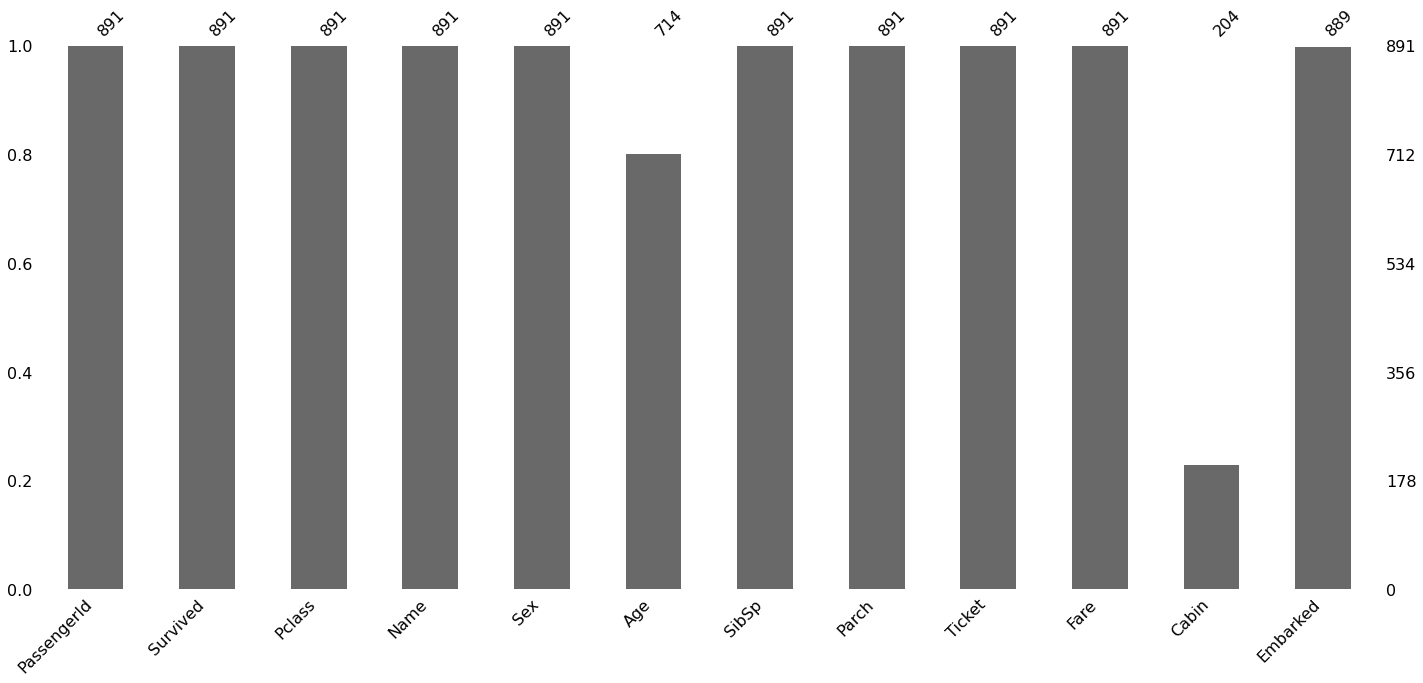

In [5]:
import missingno

missingno.bar(data)

Below Matrix Shows relative positions of missing values. From our observation we can tell there are more missing values in *Cabin* as compared to *Age* and *Embarked*

<AxesSubplot:>

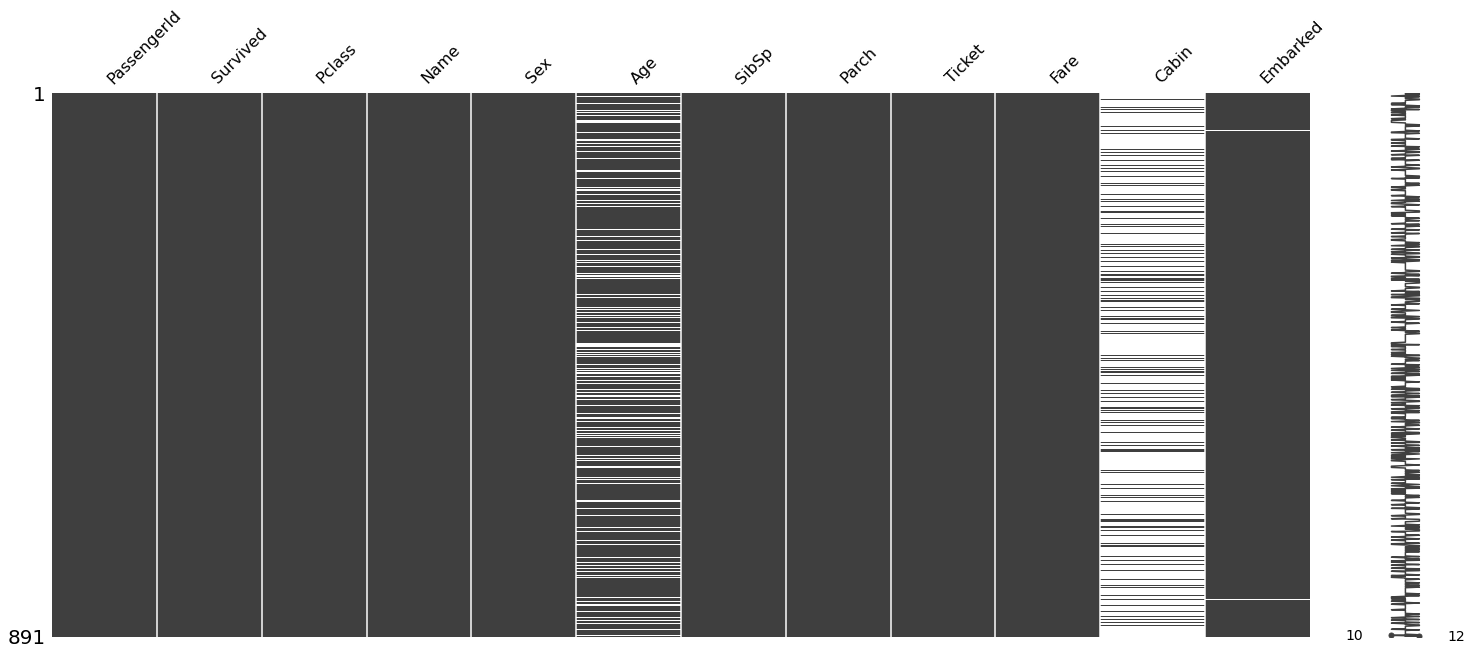

In [6]:
missingno.matrix(data)

## Missing Values Visualization

The Below Visualizations are done on the records that has missing *Age*,*Cabin* and *Embarked*

In [7]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

missing_age_cabin = data[data.Age.isnull() & data.Cabin.isnull()]

fig = make_subplots(rows=2, cols=2, subplot_titles=("Fare", "Embarked", "Pclass", "Survived"))
fig.add_trace( go.Histogram(x=missing_age_cabin.Fare) ,row=1, col=1)
fig.add_trace( go.Histogram(x=missing_age_cabin.Embarked) ,row=1, col=2)
fig.add_trace( go.Histogram(x=missing_age_cabin.Pclass) ,row=2, col=1)
fig.add_trace( go.Histogram(x=missing_age_cabin.Survived) ,row=2, col=2)

### Through our Visualization we can notice that, the people whose *Age* and *Cabin* was not recorded were mostly people :
- Who were poor
- Embarked from Southampton
- Had 3rd class tickets
- and **Did Not** Survive

## Handling missing values

## Embarked
Since there are very few rows with missing values we can remove those rows completely, as it will not have a significant effect on the performance of the model

In [8]:
clean_data = data.dropna(subset=["Embarked"]).copy()

## Age
Age is a numerical attribute, to compensate for missing values we can use mean or median. But before we do that we have to check for outliers or missing values. Since they can affect the mean.

In [9]:
#fill age with mean value

#make sure Age does not contain 0 values or outliers as it will affect mean
#checking for 0
print("rows contain 0 age: ", len(clean_data[clean_data.Age <= 0]))
px.box(clean_data.Age).show()

rows contain 0 age:  0


it seems we don't have to worry about 0's. There are very few outliers and also they are not very far apart so we can ignore them

In [10]:
#mean age
mean_age = clean_data.Age.mean()
print("mean age: ",mean_age)

clean_data.Age = clean_data.Age.fillna(mean_age).copy()
print("age with null values: ", clean_data.Age.isnull().sum())

mean age:  29.64209269662921
age with null values:  0


## Cabin

In [11]:
print("count of cabin null: ", clean_data.Cabin.isnull().sum())

count of cabin null:  687


Cabin is a Categorical attribute. We could use mode to identify and fill missing values with the most frequent appearing category but there are way too many missing values than actual values present for calculating the frequency. If mod is used it will drastically bias the frequency of categories. Thus it is better to create a new category 'Unknown' for missing Cabin values

In [12]:
clean_data.Cabin = clean_data.Cabin.fillna("unknown")

Let's check once again if we have fixed all missing values

<AxesSubplot:>

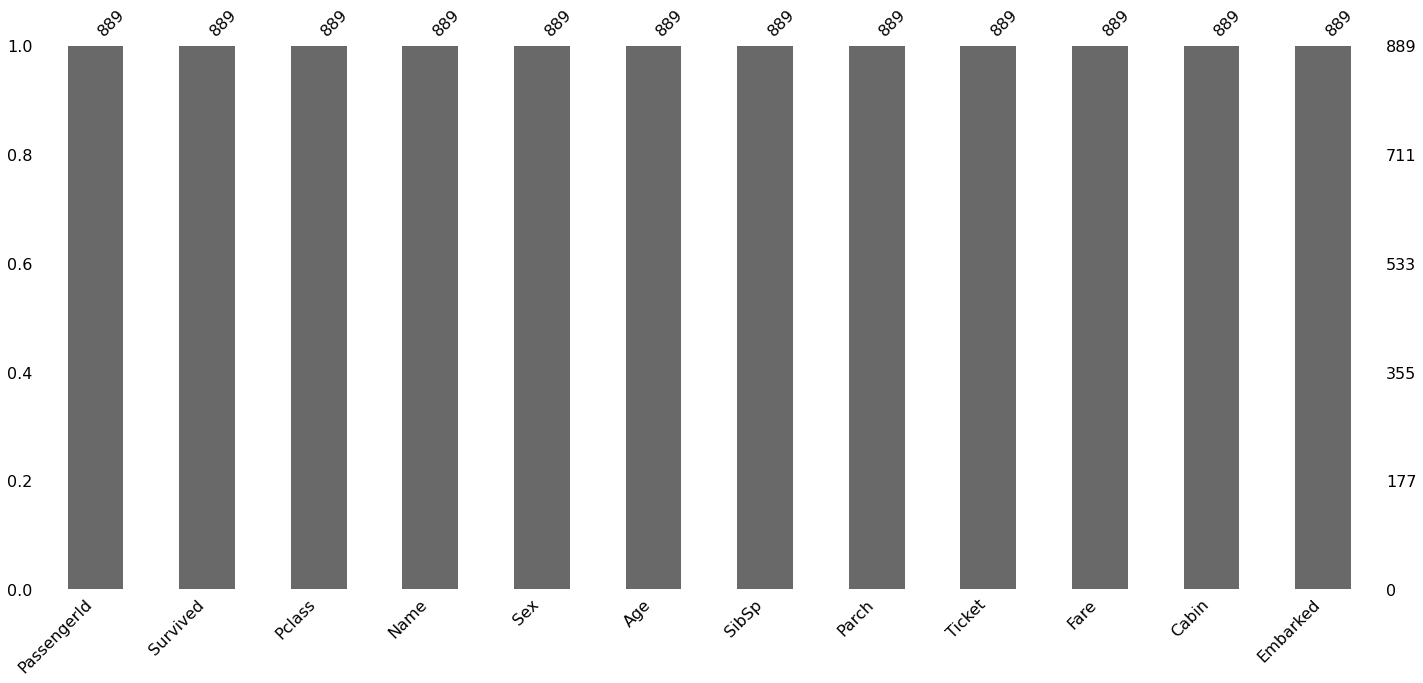

In [13]:
missingno.bar(clean_data)

It looks like there aren't anymore missing values left. We can replace the data

In [14]:
data = clean_data

# Data Analysis

## Survival Rate

In [15]:
px.pie(data, values=[1 for i in data.Survived], names="Survived", title="Survived vs Non-Survived").show()
print("Average rate of survival: ", data.Survived.mean())

Average rate of survival:  0.38245219347581555


Our observations tell us the ratio of survived vs not-survived passangers. We can see that Average rate of survival was 0.38 less than half. Which means in our overall data most passangers did not survived

## Survived along with Sex and Pclass

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

sexes = ["male", "male", "male", "female","female", "female"]
pclasses = [1,2,3, 1,2,3]

size = []
color = []
hovertext = []

for sex, pclass in zip(sexes, pclasses):
    it = data[data.Pclass == pclass]
    it = it[it.Sex==sex]
    count = len(it)
    color_data = it.Survived[it.Survived == 1].sum()
    size.append(count) 
    color.append(color_data)
    hovertext.append(('gender: {sex} <br>' + 'PClass: {pclass} <br>' + 'count: {count} <br>'+'survived: {color_data}').format(sex=sex, pclass=pclass, count=count, color_data=color_data))
    
fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(
        x=sexes, 
        y=pclasses, 
        mode="markers", 
        marker=dict(
            size=size,
            color=color,
            showscale=True
        ),
        text=hovertext    
    )
)
fig2.update_layout(
    title="PClass, Sex, Survival",
    yaxis=dict(
        title="PClass",
        gridwidth=2
    ),
    xaxis=dict(
        title="Sex",
        gridwidth=2
    )
)


### Observations:

- There is a huge difference between male survival rate and female survival rate. Most females did survived irrespective of their Pclass. 

- We can also observe that Most passangers were Male of 3rd class tickets. And their survival rate is as close as to male passangers of 1st class tickets.

- While the male passangers of 2nd class tickets had the worst chance of survival. 

- While for female passangers, There wasn't much variation in count of female passangers based on their Ticket class, their survival rate is also almost same.

- female passangers of 1st class tickets have the highest survival chance in overall data.

## Age

In [17]:
px.histogram(data.Age, title="Frequency dist. Age")

it appears the *Age* attribute is not too skewed in any direction

## Age Binning

We are going to bin the age in categories as it makes it easier for visualization and analysis.

In [18]:
data["age_binned"] = pd.cut(data['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

## Age and Survived

In [19]:
fig = go.Figure()

survived = data[data.Survived == 1]
not_survived = data[data.Survived == 0]

fig.add_trace(
    go.Histogram(x=survived.age_binned, name="survived")
)
fig.add_trace(
    go.Histogram(x=not_survived.age_binned, name="not survived")
)

fig.update_layout(
    title="Survived vs Non-Survived by Age"
)


There were mostly Adults onboard, and out of which most didn't survived

## Age along with Sex and Survival

In [20]:
sexes = ["male", "male", "male", "male", "female", "female","female", "female"]
ages = ["Adult", "Teenage", "Children", "Elder", "Adult", "Teenage", "Children", "Elder"]

size = []
color = []
hovertext = []

for sex, age in zip(sexes, ages):
    it = data[data.Sex == sex]
    it = it[it.age_binned==age]
    count = len(it)
    color_data = it.Survived[it.Survived == 1].sum()
    size.append(count) 
    color.append(color_data)
    hovertext.append(('gender: {sex} <br>' + 'AGe: {age} <br>' + 'count: {count} <br>'+'survived: {color_data}').format(sex=sex, age=age, count=count, color_data=color_data))
    
fig2 = go.Figure()

fig2.add_trace(
    go.Scatter(
        x=sexes, 
        y=ages, 
        mode="markers", 
        marker=dict(
            size=size,
            color=color,
            showscale=True
        ),
        text=hovertext    
    )
)
fig2.update_layout(
    title="Age, Sex, Survival",
    yaxis=dict(
        title="Age",
        gridwidth=2
    ),
    xaxis=dict(
        title="Sex",
        gridwidth=2
    )
)


There were mostly Male Adult Passengers onboard. Apparantly Adult Male Passengers also had higher chances of survial than Male Passengers of other age. 
Same goes for female passangers but with better chances of survival

## Family attribute
for convinience in data analysis we can create a new attribute called *Family* which is sum of Number of Siblings onboard and Parents/children onboard

In [21]:
data['family'] = data.SibSp + data.Parch

## Age, Family Size and avg Survived

In [22]:
px.density_heatmap(data, x="family", y="age_binned", z="Survived", histfunc="avg", text_auto=True, title="Survival rate by age and Family size").show()
px.density_heatmap(data, x="family", y="age_binned", text_auto=True, title="count by age and Family size ").show()

**First Heatmap:**

First heatmap has age on Y-axis, family size on X-axis and average of survived on Z-axis. Our observations are:

- There are passengers having a family size as large as 10
- Passengers with large family sizes mostly more than 5 tend to not survive
- Passengers with very small family didn't had a best survival rate either.
- Childern had best chance of survival.
- Mostly Passengers having a family size of between 1 and 3 inclusive had the best chance of survival 

**Second Heatmap:**

Second heatmap shows just count of passengers on same parameters as the first heatmap. For Convinience.

## Fare

In [23]:
px.histogram(x=data.Fare)

it seems that the graph is right skewed. Most pasangers onboard were poor. And there were people who had paid 0 for fare price. 

## Fare Binning

In [24]:
data["fare_binned"] = pd.cut(data['Fare'], bins=[-1,40,100,300, 550], labels=['Poor','Mediocre','Rich','Very Rich'])

## Fare with Survied

In [25]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=data[data.Survived == 1].fare_binned, histfunc="avg", name="Survived", marker_color='#fa9c3b'))
fig.add_trace(go.Histogram(x=data[data.Survived == 0].fare_binned, histfunc="avg", name="Not-Survived", marker_color='#330C73'))

we already know most passengers onboard were poor.

it seems that the graph is biased by the quantity. Since it seems like poor people had higher chance of survival. But we already know through other measures that the People with 3rd Ticket had lower chances of survival. 

## Fare with Age and Survived

In [26]:
px.density_heatmap(data, x="fare_binned", y="age_binned", z="Survived", histfunc="avg", text_auto=True, title="AVG survival by age and fare").show()
px.density_heatmap(data, x="fare_binned", y="age_binned", z="Survived", text_auto=True, title="count by age and fare").show()

It seems most rich passengers did survived. Although we can not assume that richer passengers had better chances of survival than Poor Passengers after looking at the second heatmap that shows count. As we can see the outcomes are biased by quantity. There were fewer richer passengers and most of them survived irrespective of poor passengers. 

## Embarked

In [27]:
fig = go.Figure()

emb_s = data[data.Embarked == "S"]
emb_q = data[data.Embarked == "Q"]
emb_c = data[data.Embarked == "C"]
fig.add_trace(go.Histogram(x=emb_s.Sex, y=emb_s.Survived, histfunc="avg", name="S"))
fig.add_trace(go.Histogram(x=emb_c.Sex, y=emb_c.Survived, histfunc="avg", name="C"))
fig.add_trace(go.Histogram(x=emb_q.Sex, y=emb_q.Survived, histfunc="avg", name="Q"))

It seems out of most of the people that were onboard most were females and they embarked from Southampton. Same for male passengers.

# Data Preprocessing

## Feature engineering

Most of the feature engireering is already done when we created following additional attributes:

- family
- age_binned
- fare_binned

## OneHot Encoding

In [28]:
from sklearn import preprocessing
prepared_data = data.copy()
labels = ['age_binned', 'fare_binned', 'Embarked', 'Pclass']

enc_hot = preprocessing.OneHotEncoder()
fitted_values = enc_hot.fit_transform(prepared_data[labels]).toarray()

cats = []

for category in enc_hot.categories_:
    for c in category:
        cats.append(c)

prepared_data[cats] = fitted_values

prepared_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Mediocre,Poor,Rich,Very Rich,C,Q,S,1,2,3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Removing the attributes that we don't need after encoding such as Fare, Age, fare_binned, age_binned, and attributes that don't provide any value to the model such as Name, Ticket, Cabin etc.

In [29]:
prepared_data = prepared_data.drop(['Age', 'Fare', 'Pclass', 'Embarked', 'age_binned', 'fare_binned', 'Name', 'Ticket', 'Fare', 'PassengerId', 'Cabin'], axis=1)

## Label Encoding

Encoding labels of Sex attribute

In [30]:
le = preprocessing.LabelEncoder()
transformed = le.fit_transform(prepared_data.Sex)
prepared_data.Sex = transformed

Rename columns for easy understanding

In [31]:
prepared_data.columns

Index([ 'Survived',       'Sex',     'SibSp',     'Parch',    'family',
           'Adult',  'Children',     'Elder',   'Teenage',  'Mediocre',
            'Poor',      'Rich', 'Very Rich',         'C',         'Q',
               'S',           1,           2,           3],
      dtype='object')

In [32]:
prepared_data.columns = [ 'Survived',       'Sex',     'SibSp',     'Parch',
          'family',  'Mediocre',      'Poor',      'Rich', 'Very Rich',     'Adult',  'Children',     'Elder',   'Teenage',
                 'Class1',           'Class2',           'Class3',         'PortC',         'PortQ',
               'PortS']

Final Results

In [33]:
pd.set_option('display.max_columns', None)
prepared_data

,Survived,Sex,SibSp,Parch,family,Mediocre,Poor,Rich,Very Rich,Adult,Children,Elder,Teenage,Class1,Class2,Class3,PortC,PortQ,PortS
0,0,1,1,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1,0,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1,0,1,0,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
887,1,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
888,0,0,1,2,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
889,1,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Model fitting

When training machine learning models it is often considered a good practise to experiment with attributes and models. To figure out which configuration gives best results. Thus we are also going to train 2 models. One would fit above data where age and fare are binned. The other would fit the data where age and fare are not binned but standardized.

## Model 1
Deciding column names for Dependend and Independent variables and splitting data into test and train datasets using sklearn.

In [34]:
X_cols = prepared_data.columns[[y for y in prepared_data.columns != 'Survived']]
Y_cols = 'Survived'

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(prepared_data[X_cols], prepared_data[Y_cols], test_size=0.33, random_state=42)

In [36]:
X_train

,Sex,SibSp,Parch,family,Mediocre,Poor,Rich,Very Rich,Adult,Children,Elder,Teenage,Class1,Class2,Class3,PortC,PortQ,PortS
6,1,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
576,0,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
445,1,0,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
74,1,0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
670,0,1,1,2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
271,1,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
862,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
436,0,2,2,4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [37]:
from sklearn.linear_model import LogisticRegression
lf = LogisticRegression().fit(X_train, y_train)

In [38]:
lf.score(X_test, y_test)

0.8095238095238095

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, lf.predict(X_test))

array([[158,  26],
       [ 30,  80]])

## Model 2

We will start by copying the previous data model was fitted with

In [40]:
import numpy as np
temp = prepared_data.copy()

Then we will drop binned attributes of Age and Fare such as Mediocre, Rich, Adult, Teenage etc. And add two attributes Age and Fare that are taken from the original cleaned data. 

In [41]:
temp = temp.drop([ "Mediocre", "Poor", "Rich", "Very Rich", "Adult", "Children", "Teenage", "Elder"], axis=1)
temp["Age"] = data.Age
temp["Fare"]=data.Fare

Then we will standardize the Age and Fare attributes since they are continous numerical attributes

In [42]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformed_age = scaler.fit_transform(np.array(temp.Age).reshape(-1, 1))
transformed_fare = scaler.fit_transform(np.array(temp.Fare).reshape(-1, 1))
temp.Age = transformed_age
temp.Fare = transformed_fare
temp

,Survived,Sex,SibSp,Parch,family,Class1,Class2,Class3,PortC,PortQ,PortS,Age,Fare
0,0,1,1,0,1,0.0,0.0,1.0,0.0,0.0,1.0,-5.896199e-01,-0.500240
1,1,0,1,0,1,1.0,0.0,0.0,1.0,0.0,0.0,6.448480e-01,0.788947
2,1,0,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,-2.810029e-01,-0.486650
3,1,0,1,0,1,0.0,0.0,1.0,1.0,0.0,0.0,4.133853e-01,0.422861
4,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,1.0,4.133853e-01,-0.484133
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,-2.038487e-01,-0.384475
887,1,0,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,-8.210826e-01,-0.042213
888,0,0,1,2,3,0.0,0.0,1.0,0.0,0.0,1.0,-5.482138e-16,-0.174084
889,1,1,0,0,0,1.0,0.0,0.0,1.0,0.0,0.0,-2.810029e-01,-0.042213


Split the data and fit the model

In [43]:
from sklearn.model_selection import train_test_split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(temp[["Sex", "SibSp", "Parch","Class1", "Class2", "Class3", "PortC", "PortQ", "PortS", "Age", "Fare"]], temp["Survived"], test_size=0.33, random_state=42)

In [44]:
X_train_2

,Sex,SibSp,Parch,Class1,Class2,Class3,PortC,PortQ,PortS,Age,Fare
6,1,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.879316e+00,0.397946
576,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,3.362310e-01,-0.384475
445,1,0,2,0.0,0.0,1.0,1.0,0.0,0.0,-1.978396e+00,1.001854
74,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,1.819225e-01,0.491229
670,0,1,1,0.0,0.0,1.0,0.0,1.0,0.0,7.991565e-01,0.138985
...,...,...,...,...,...,...,...,...,...,...,...
107,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,-5.482138e-16,-0.489670
271,1,0,0,0.0,0.0,1.0,0.0,0.0,1.0,-3.581571e-01,-0.646204
862,0,0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.416390e+00,-0.124170
436,0,2,2,0.0,0.0,1.0,0.0,0.0,1.0,-6.667741e-01,0.045870


In [45]:
from sklearn.linear_model import LogisticRegression
lf_2 = LogisticRegression().fit(X_train_2, y_train_2)

In [46]:
lf_2.score(X_test_2, y_test_2)

0.8197278911564626

In [47]:
confusion_matrix(y_test_2, lf_2.predict(X_test_2))

array([[160,  24],
       [ 29,  81]])

It seems the second model has slightly better performance then the other first one.

# Submission

In [48]:
test_data = test.copy()

## Cleaning

In [49]:
print("Empty values before: ")
print(test_data.isnull().sum())

#fill age with mean value
test_data.Age =test_data.Age.fillna(test_data.Age.mean()).copy()
#create new value unknown for cabin
test_data.Cabin = test_data.Cabin.fillna("unknown")
#fill missing fare values with average
test_data.Fare =test_data.Fare.fillna(test_data.Fare.mean()).copy()

print("Empty values after: ")
print(test_data.isnull().sum())

Empty values before: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
Empty values after: 
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## standardization

In [50]:
scaler = StandardScaler()
transformed_age_test = scaler.fit_transform(np.array(test_data.Age).reshape(-1, 1))
transformed_fare_test = scaler.fit_transform(np.array(test_data.Fare).reshape(-1, 1))
test_data.Age = transformed_age_test
test_data.Fare = transformed_fare_test

## onehot encoding

In [51]:
enc_hot = preprocessing.OneHotEncoder()
fitted_values = enc_hot.fit_transform(test_data[["Embarked", "Pclass"]]).toarray()

cats = []

for category in enc_hot.categories_:
    for c in category:
        cats.append(c)

test_data[cats] = fitted_values

## label encoding

In [52]:
le = preprocessing.LabelEncoder()
test_data.Sex = le.fit_transform(test_data.Sex)

## removing and renaming attributes

In [53]:
temp_test_data = test_data.drop(['PassengerId', 'Pclass', 'Name', 'Embarked', 'Ticket', 'Cabin'], axis=1)
print(temp_test_data.columns)
temp_test_data.columns = ['Sex','Age','SibSp','Parch', 'Fare','PortC', 'PortQ','PortS','Class1','Class2','Class3']

test_data = temp_test_data.copy()

Index(['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'C', 'Q', 'S', 1, 2, 3], dtype='object')


In [54]:
test_data

,Sex,Age,SibSp,Parch,Fare,PortC,PortQ,PortS,Class1,Class2,Class3
0,1,0.334993,0,0,-0.498407,0.0,1.0,0.0,0.0,0.0,1.0
1,0,1.325530,1,0,-0.513274,0.0,0.0,1.0,0.0,0.0,1.0
2,1,2.514175,0,0,-0.465088,0.0,1.0,0.0,0.0,1.0,0.0
3,1,-0.259330,0,0,-0.483466,0.0,0.0,1.0,0.0,0.0,1.0
4,0,-0.655545,1,1,-0.418471,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
413,1,0.000000,0,0,-0.494448,0.0,0.0,1.0,0.0,0.0,1.0
414,0,0.691586,0,0,1.313753,1.0,0.0,0.0,1.0,0.0,0.0
415,1,0.651965,0,0,-0.508792,0.0,0.0,1.0,0.0,0.0,1.0
416,1,0.000000,0,0,-0.494448,0.0,0.0,1.0,0.0,0.0,1.0


In [55]:
#reorder columns
test_data = test_data[['Sex', 'SibSp', 'Parch', 'Class1', 'Class2', 'Class3', 'PortC', 'PortQ','PortS', 'Age', 'Fare']]
predictions = lf_2.predict(test_data)
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [56]:
submission= pd.DataFrame({"PassengerId":test["PassengerId"],"Survived":predictions})
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [57]:
submission.to_csv('submission.csv', index=False)